In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '../gridded')
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import MultiPoint

import cell_tree2d

import interpolate

First let's make a sample curvilinear grid. The size is given by Nx, and Ny

In [29]:
Nx = 80
Ny = 60

def make_sample_grid(Ny, Nx):
    'return sample grid of dimension [Ny, Nx]'
    yc, xc = np.mgrid[1:10:Ny*1j, 1:20:Nx*1J]

    def rot2d(x, y, ang):
        '''rotate vectors by geometric angle'''
        xr = x*np.cos(ang) - y*np.sin(ang)
        yr = x*np.sin(ang) + y*np.cos(ang)
        return xr, yr

    x, y = rot2d(xc, (5+yc)**1.2*(3+xc)**0.3, 0.2)

    y /= y.ptp()/10.
    x /= x.ptp()/10.

    x -= x.mean()
    y -= y.mean()

    return x, y

x, y = make_sample_grid(Ny, Nx)

Now some trial points where the gridded values will be interpolated. These cover a number of test cases at specific grid locations, or random points.  

In [78]:
# Some sample grid locations
x_nodes, y_nodes = x.flatten(), y.flatten()

x_u = 0.5*(x[:, 1:] + x[:, :-1]).flatten()
y_u = 0.5*(y[:, 1:] + y[:, :-1]).flatten()

x_v = 0.5*(x[1:, :] + x[:-1, :]).flatten()
y_v = 0.5*(y[1:, :] + y[:-1, :]).flatten()

x_centers = 0.25*(x[1:, 1:] + x[1:, :-1] + x[:-1, 1:] + x[:-1, :-1]).flatten()
y_centers = 0.25*(y[1:, 1:] + y[1:, :-1] + y[:-1, 1:] + y[:-1, :-1]).flatten()

# centers offset halfway toward the lower right node
x_nc = 0.5*(0.25*(x[1:, 1:] + x[1:, :-1] + x[:-1, 1:] + x[:-1, :-1]) + x[:-1, 1:]).flatten()
y_nc = 0.5*(0.25*(y[1:, 1:] + y[1:, :-1] + y[:-1, 1:] + y[:-1, :-1]) + y[:-1, 1:]).flatten()

x_rand, y_rand = 3.0*np.random.randn(2, 100000)

Change the values of points, xi, and yi to the desired points to test.

In [79]:
points = np.vstack((x_rand, y_rand)).T
xi, yi = points.T

Generate the cell tree, locate the points

In [80]:
nodes, faces = interpolate.array2grid(x, y)
squares = np.array([nodes[face] for face in faces])

ct2d = cell_tree2d.CellTree(nodes, faces)
gridpoint_indices = ct2d.locate(points)

Sanity check. See if cell_tree2d really finds the right cell. This can take some time....

In [81]:
eps = 0.01    # some buffering required if the points are along the edge of a square.

# remove indices with value -1, outside the grid domain
inside = gridpoint_indices >= 0    # good points, inside domain
gridpoint_indices = gridpoint_indices[inside]

points_i = points[inside]
squares_i = squares[gridpoint_indices]

mesh = MultiPolygon([Polygon(p).buffer(eps) for p in squares_i])
trial = MultiPoint([Point(p) for p in points_i])

contains = [m.contains(p) for m, p in zip(mesh, trial)]

assert(np.alltrue(contains))


Now check interpolation. This is fast..

In [82]:
def zfunc(x, y):
    'Sample field for interpolation'
    return np.sin(x/10.) + np.cos(y/10.)

ct = interpolate.CellTree(x, y)
loc = ct.locate(points)
zgrid = zfunc(x, y)
zi = loc.interpolate(zgrid)

# use loc.points, as this contains only the points in the domain.
zi_true = zfunc(*loc.points.T)

assert(np.allclose(zi, zi_true, rtol=0.0001))


Plot this up some..

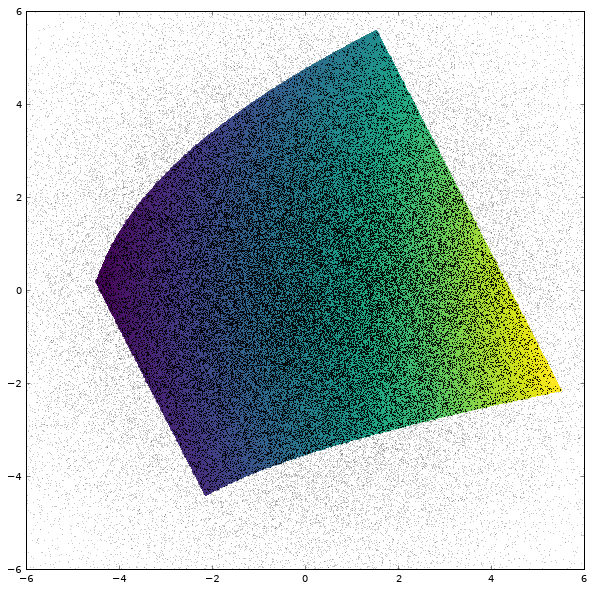

In [83]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

zc = zfunc( 0.25*(x[1:, 1:] + x[1:, :-1] + x[:-1, 1:] + x[:-1, :-1]), 
            0.25*(y[1:, 1:] + y[1:, :-1] + y[:-1, 1:] + y[:-1, :-1]) )
ax.pcolormesh(x, y, zgrid, cmap='viridis', clim=(0.5, 1.5))

# we only want to plot the points that are within the grid domain.
ax.scatter(loc.points[:, 0], loc.points[:, 1], 10, zi, cmap='viridis', edgecolor='none')

ax.plot(xi, yi, '.k', alpha=0.5, markersize=0.5)   # all points
ax.plot(loc.points[:, 0], loc.points[:, 1], '.k', markersize=1)   # only points in the domain


ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

ax.set_aspect(1.0)